In [25]:
%matplotlib inline
from pandas_datareader import data
import pandas as pd
from SALib.sample import latin
from stockmarket.stylizedfacts import *
from stockmarket.evolutionaryalgo import *
from tqdm import tqdm
import matplotlib.pyplot as plt

# Evolutionary algorithm to calibrate model

## 1 get data from S&P500

In [2]:
start_date = '2010-01-01'
end_date = '2016-12-31'

spy = data.DataReader("SPY", 
                       start=start_date, 
                       end=end_date, 
                       data_source='google')['Close']
spy_returns = spy.pct_change()[1:]

spy_volume = data.DataReader("SPY", 
                       start=start_date, 
                       end=end_date, 
                       data_source='google')['Volume']

In [3]:
spy_autocorrelation = autocorrelation_returns(spy_returns, 25)
spy_kurtosis = kurtosis(spy_returns)
spy_autocorrelation_abs = autocorrelation_abs_returns(spy_returns, 25)
spy_hurst = hurst(spy, lag1=2 , lag2=20)
spy_cor_volu_vola = correlation_volume_volatility(spy_volume, spy_returns, window=10)
stylized_facts_spy = [spy_autocorrelation, spy_kurtosis, spy_autocorrelation_abs, spy_hurst, spy_cor_volu_vola]

pd.DataFrame(stylized_facts_spy, columns=['S&P500'], 
             index=['autocorrelation', 'kurtosis', 'autocorrelation_abs', 'hurst', 'correlation_volume_volatility'])

,S&P500
autocorrelation,-0.005401
kurtosis,3.215531
autocorrelation_abs,-0.001990
hurst,0.410180
correlation_volume_volatility,0.246848


## Define parameter space bounds 

We define the parameter bounds as follows. 

| Parameter | Values (start, stop, step) |
| -------------| ------------|
| share_chartists       | 0 - 1, 0.1      |
| share_mean_reversion       | 0 - 1, 0.1   |
| order_expiration_time       | 1000 - 10000, 1000      |
| agent_order_price_variability       | 1 - 10, 1      |
| agent_order_variability       | 0.1 - 5       |
| agent_ma_short       | 5 - 100, 5      |
| agent_ma_long       | 50 - 400, 50      |
| agents_hold_thresholds       | 0.0005        |
| Agent_volume_risk_aversion       | 0.1 - 1, 0.1      |
| Agent_propensity_to_switch       | 0.1 - 2.2, 0.1      |
| profit_announcement_working_days       | 5 - 50, 5       |
| price_to_earnings_spread       | 5 - 50, 5       |
| price_to_earnings_heterogeneity       | 5 - 50, 5       |

In [5]:
parameter_space = {'share_chartists':[0.0, 1.0], 'share_mean_reversion':[0.0, 1.0], 'order_expiration_time':[1000, 10000], 
                   'agent_order_price_variability':[1, 10], 'agent_order_variability':[0.1, 5.0], 
                   'agent_ma_short':[5, 100], 'agent_ma_long':[50, 400], 'agents_hold_thresholds':[0.00005,0.01],
                   'agent_volume_risk_aversion':[0.1, 1.0], 'agent_propensity_to_switch':[0.1, 2.2], 
                   'profit_announcement_working_days':[5, 50], 'price_to_earnings_base':[10,20], 
                   'price_to_earnings_heterogeneity':[1.1,2.5], 'price_to_earnings_gap':[4,20],
                   'longMA_heterogeneity':[1.1,1.8], 'shortMA_heterogeneity':[1.1,1.8], 'shortMA_memory_divider':[1, 10]}

In [6]:
problem = {
  'num_vars': 17,
  'names': ['share_chartists', 'share_mean_reversion', 'order_expiration_time', 'agent_order_price_variability', 
            'agent_order_variability', 'agent_ma_short', 'agent_ma_long', 'agents_hold_thresholds',
           'agent_volume_risk_aversion', 'agent_propensity_to_switch', 'profit_announcement_working_days',
           'price_to_earnings_base', 'price_to_earnings_heterogeneity', 'price_to_earnings_gap',
           'longMA_heterogeneity', 'shortMA_heterogeneity', 'shortMA_memory_divider'],
  'bounds': [[0.0, 1.0], [0.0, 1.0], [1000, 10000], [1, 10], 
             [0.1, 5.0], [5, 100], [50, 400], [0.00005,0.01], 
             [0.1, 1], [0.1, 2.2], [5, 50],
             [10,20], [1.1,2.5], [4,20],
             [1.1,1.8], [1.1,1.8], [1, 10]]
}

# Sample the parameter space using a latin hypercube

In [18]:
population_size = 10

In [19]:
latin_hyper_cube = latin.sample(problem=problem, N=population_size)
latin_hyper_cube = latin_hyper_cube.tolist()

In [20]:
# transform some of the parameters to integer
for idx, parameters in enumerate(latin_hyper_cube):
    latin_hyper_cube[idx][2] = int(latin_hyper_cube[idx][2])
    latin_hyper_cube[idx][3] = int(latin_hyper_cube[idx][3])
    latin_hyper_cube[idx][4] = int(latin_hyper_cube[idx][4])
    latin_hyper_cube[idx][5] = int(latin_hyper_cube[idx][5])
    latin_hyper_cube[idx][6] = int(latin_hyper_cube[idx][6])
    latin_hyper_cube[idx][10] = int(latin_hyper_cube[idx][10])
    latin_hyper_cube[idx][11] = int(latin_hyper_cube[idx][11])
    latin_hyper_cube[idx][13] = int(latin_hyper_cube[idx][13])
    latin_hyper_cube[idx][16] = int(latin_hyper_cube[idx][16])

# Run evolutionary algorithm

In [21]:
# create initial population
population = []
for parameters in latin_hyper_cube:
    population.append(Individual(parameters, [], np.inf))
all_populations = [population]
av_pop_fitness = []

In [22]:
# fixed parameters
iterations = 10
SIMTIME = 200
NRUNS = 2
backward_simulated_time = 400
initial_total_money = 26000
init_profit = 1000
init_discount_rate = 0.17
number_of_agents = 500

In [23]:
for i in tqdm(range(iterations)):
    simulated_population, fitness = simulate_population(all_populations[i], number_of_runs=NRUNS, simulation_time=SIMTIME, 
                                                        number_of_agents=number_of_agents, init_tot_money=initial_total_money, 
                                                        init_profit=init_profit, 
                                                        init_discount_rate=init_discount_rate, 
                                                        stylized_facts_real_life=stylized_facts_spy)
    av_pop_fitness.append(fitness)
    all_populations.append(evolve_population(simulated_population, fittest_to_retain=0.3, random_to_retain=0.2, 
                                             parents_to_mutate=0.3, parameters_to_mutate=0.1, problem=problem))  

  0%|                                                   | 0/10 [00:00<?, ?it/s]C:\Users\p267237\Documents\GitHub\abm\stockmarket\stylizedfacts.py:122: RuntimeWarning: divide by zero encountered in log
  m = np.polyfit(np.log(lags), np.log(std_differences), 1)
 30%|████████████▌                             | 3/10 [17:12<40:34, 347.76s/it]

no volume
no volume

 40%|████████████████▊                         | 4/10 [22:34<34:00, 340.12s/it]


no volume

100%|█████████████████████████████████████████| 10/10 [55:49<00:00, 328.34s/it]

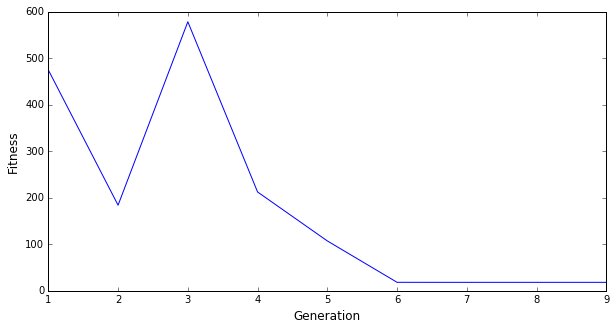

In [26]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(av_pop_fitness)), av_pop_fitness)
ax1.set_ylabel('Fitness', fontsize='12')
ax1.set_xlabel('Generation', fontsize='12')

In [42]:
all_populations[4][1].stylized_facts

[-0.021935889656600323,
 0.1412292253510814,
 -0.00091449309021917474,
 0.0027926507298680439,
 0.14321366251604462]

In [30]:
stylized_facts_spy

[-0.0054007759741784957,
 3.2155306317147674,
 -0.0019895273229147427,
 0.41017963201431029,
 0.24684797017457794]